In [79]:
import os
import sys
from tqdm import tqdm
import numpy as np
sys.path.append('..')

from utils.PAD_datamodule import PADDataModule
from utils.tools import font_colors
from utils.settings.config import RANDOM_SEED, CROP_ENCODING, LINEAR_ENCODER, CLASS_WEIGHTS, BANDS

import cv2
import matplotlib.pyplot as plt

In [10]:
rootdir = '/home/jovyan/shared_volume/data/newdata'
imgdir = os.path.join(rootdir, 'nrgb')
labeldir = os.path.join(rootdir, 'label')

imglist = os.listdir(imgdir)

In [15]:
catalonia_name = ['31TCG', '31TDG', '31TCF', '31TBF', '31TCG', '31TDF']

catalonia_filelist = []
france_2019_filelist = []
for x in imglist:
    if x.split('_')[1] in catalonia_name:
        catalonia_filelist.append(x)
    else:
        france_2019_filelist.append(x)
        
catalonia_2019_filelist = [x for x in catalonia_filelist if '2019' in x]
catalonia_2020_filelist = [x for x in catalonia_filelist if '2020' in x]
print(len(catalonia_2019_filelist), len(catalonia_2020_filelist), len(france_2019_filelist))

1033 1018 2435


In [137]:
selected_classes = {
    '110': 'Wheat',
    '120': 'Maize',
    '140': 'Sorghum',
    '150': 'Barley',
    '160': 'Rye',
    '170': 'Oats',
    '330': 'Grapes',
    '435': 'Rapeseed',
    '438': 'Sunflower',
    '510': 'Potatoes',
    '770': 'Peas',
}


In [153]:
def ndvi(img):
    nir = img[:,3]
    red = img[:,2]
    ndvi = (nir-red) / (nir+red+1e-6)
    return ndvi

def calc_ndvi(rootdir, filename, pred_code=110):
    imgdir = os.path.join(rootdir, 'nrgb')
    labeldir = os.path.join(rootdir, 'label')
    
    img = np.load(os.path.join(imgdir, filename))
    
    img_ndvi = ndvi(img)

    label = np.load(os.path.join(labeldir, filename))

    mask = label == 0
    kernel = np.ones((3,3), np.uint8)
    mask_erode = cv2.dilate(mask.astype('uint8'), kernel)
    label[mask_erode==1] = 0
    
    # label[mask == 1] = 0
    
    label_mask = label == pred_code
    num_of_labelpixel = np.sum(label_mask)
    if num_of_labelpixel == 0:
        mean_ndvi = np.zeros(12)
    else:
        mean_ndvi = np.mean(img_ndvi[:,label_mask], axis=1)
    return mean_ndvi, num_of_labelpixel

def get_mean_trends(filelist, pred_code=110):
    ndvis = []
    num_pixels = []

    for filename in tqdm(filelist):
        mean_ndvi, num_of_labelpixel = calc_ndvi(rootdir, filename, pred_code=pred_code)

        if num_of_labelpixel == 0:
            pass
        else:
            ndvis.append(mean_ndvi*num_of_labelpixel)
            num_pixels.append(num_of_labelpixel)
            
    ndvis = np.asarray(ndvis)
    calc = ndvis / np.array(num_pixels)[:,np.newaxis]
    calc_mask = calc > 1
    calc[calc_mask] = np.nan
    calc_mean = np.nanmean(calc, axis=0)
    
    return calc_mean

In [156]:
pred_code = 120 # Wheat
catalonia_2019_trends = get_mean_trends(catalonia_2019_filelist, pred_code=pred_code)
catalonia_2020_trends = get_mean_trends(catalonia_2020_filelist, pred_code=pred_code)
france_2019_trends = get_mean_trends(france_2019_filelist, pred_code=pred_code)

100%|██████████| 2435/2435 [00:40<00:00, 60.04it/s]


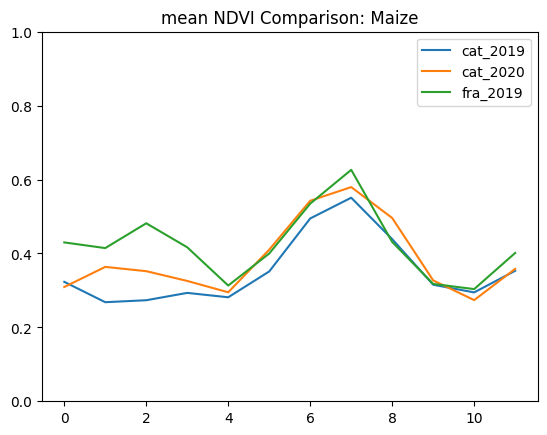

In [157]:
plt.title(f'mean NDVI Comparison: {selected_classes[str(pred_code)]}')
plt.plot(catalonia_2019_trends, label='cat_2019')
plt.plot(catalonia_2020_trends, label='cat_2020')
plt.plot(france_2019_trends, label='fra_2019')
plt.ylim([0, 1])
plt.legend()
plt.show()